# DAX Benchmarks

In [15]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sempy.fabric as fabric
import statistics as stats
import time

from pyspark.sql import functions as F

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 3, Finished, Available, Finished)

## Parameters

In [ ]:
WORKSPACE = None  # same workspace as notebook/lakehouse; set name/ID if needed

DATASETS = {
    "SS": "Star Schema",
    "USS": "Unified Star Schema",
}

WARMUP_RUNS = 0
MEASURED_RUNS = 1

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 4, Finished, Available, Finished)

## Helpers

In [17]:
# Global accumulator for all runs
GLOBAL_RUNS = []

# Fact table mapping
FACT_FOR_MEASURE_PREFIX = {
    "SS": {
        "fact": "fact__sales",
        "fact_ret": "fact__returns",
        "fact_inv": "fact__inventory",
    },
    "USS": {
        "fact": "_bridge",
        "fact_ret": "_bridge",
        "fact_inv": "_bridge",
    }
}


StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 5, Finished, Available, Finished)

In [18]:
def run_one_dax(dataset_name: str, dax: str, workspace=None) -> pd.DataFrame:
    return fabric.evaluate_dax(dataset=dataset_name, dax_string=dax, workspace=workspace)

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 6, Finished, Available, Finished)

In [19]:
def run_query(dataset_name: str, suite_key: str, group_name: str, qname: str, dax: str, workspace=None):
    """
    Runs warmups + measured repetitions.
    Stops immediately on error.
    """
    runs_rows_local = []
    seq = 0
    stop_reason = "completed"

    def record(run_phase: str, rep_n: int, duration_ms: float, df, err: str | None):
        nonlocal seq
        seq += 1
        row_count = None if df is None else int(len(df))
        col_count = None if df is None else int(df.shape[1])

        runs_rows_local.append({
            "dataset": dataset_name,
            "suite": suite_key,
            "query_group": group_name,
            "query_name": qname,
            "phase": run_phase,
            "repeat_n": rep_n,
            "seq_in_query": seq,
            "duration_ms": float(duration_ms),
            "row_count": row_count,
            "col_count": col_count,
            "error": err,
        })

    # ---- Warmups ----
    for w in range(1, WARMUP_RUNS + 1):
        t0 = time.perf_counter()
        df = None
        err = None
        try:
            df = run_one_dax(dataset_name, dax, workspace=workspace)
        except Exception as e:
            err = str(e)
        t1 = time.perf_counter()
        record("warmup", w, (t1 - t0) * 1000.0, df, err)
        
        if err:
            stop_reason = "error_in_warmup"
            runs_rows_local[-1]["stop_reason"] = stop_reason
            return runs_rows_local, stop_reason

    # ---- Measured ----
    for m in range(1, MEASURED_RUNS + 1):
        t0 = time.perf_counter()
        df = None
        err = None
        try:
            df = run_one_dax(dataset_name, dax, workspace=workspace)
        except Exception as e:
            err = str(e)
        t1 = time.perf_counter()
        record("measured", m, (t1 - t0) * 1000.0, df, err)

        if err:
            stop_reason = "error"
            runs_rows_local[-1]["stop_reason"] = stop_reason
            return runs_rows_local, stop_reason

    if runs_rows_local:
        runs_rows_local[-1]["stop_reason"] = stop_reason

    return runs_rows_local, stop_reason

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 7, Finished, Available, Finished)

In [20]:
def run_and_plot(group, name, template):
    print(f"--- Running {name} ({group}) ---")
    local_runs = []
    
    for suite_key, dataset_name in DATASETS.items():
        mapping = FACT_FOR_MEASURE_PREFIX[suite_key]
        dax = template.format(**mapping)
        
        # Call simplified run_query
        rr, stop_reason = run_query(
            dataset_name=dataset_name,
            suite_key=suite_key,
            group_name=group,
            qname=name,
            dax=dax,
            workspace=WORKSPACE
        )
        local_runs.extend(rr)
        print(f"[{suite_key}] Stop reason: {stop_reason}")
        
    # Append to global
    GLOBAL_RUNS.extend(local_runs)
    
    # Plot
    df = pd.DataFrame(local_runs)
    if not df.empty:
        measured = df.query("phase == 'measured' and error.isna()")
        if not measured.empty:
            stats = measured.groupby("dataset")["duration_ms"].median()
            ax = stats.plot.barh(figsize=(8, 3), title=f"Median Duration: {name}")
            ax.set_xlabel("ms")
            plt.show()

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 8, Finished, Available, Finished)

## Queries

### Single Fact

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 9, Finished, Available, Finished)

--- Running P1_sales_by_year (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


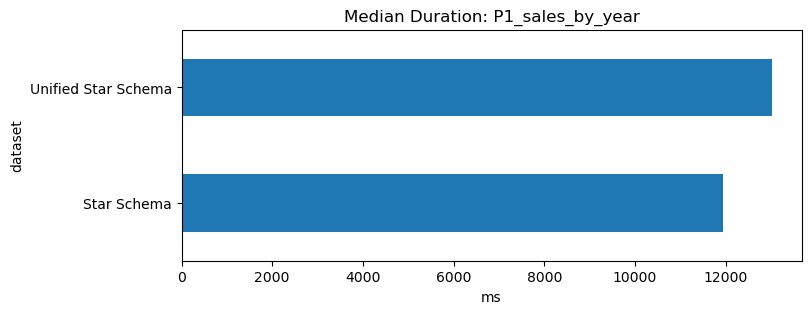

In [21]:
run_and_plot("Single Fact", "P1_sales_by_year", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
ORDER BY 'dim__date'[year]
""")

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 10, Finished, Available, Finished)

--- Running P2_sales_by_year_category (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


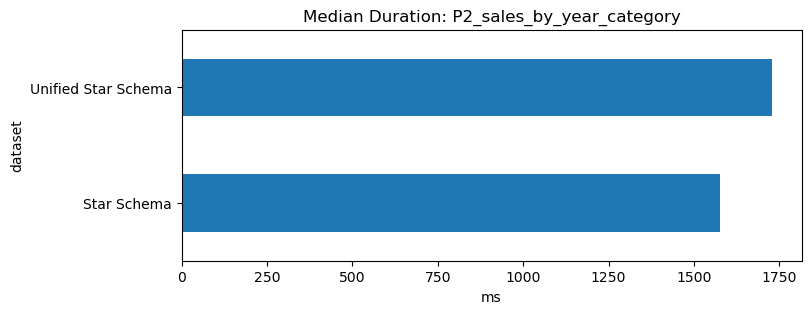

In [22]:
run_and_plot("Single Fact", "P2_sales_by_year_category", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__item'[category],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
ORDER BY 'dim__date'[year], 'dim__item'[category]
""")

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 11, Finished, Available, Finished)

--- Running P3_sales_many_groups (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


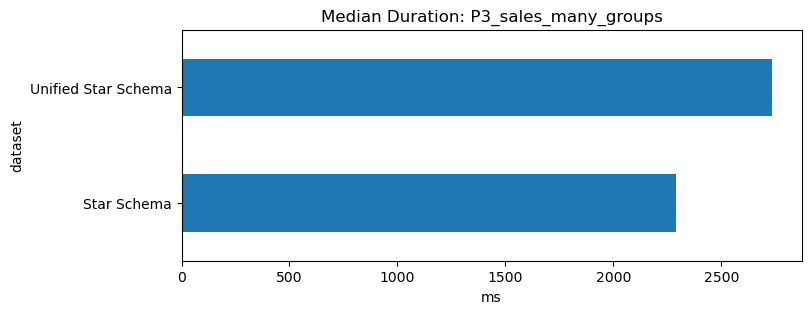

In [23]:
run_and_plot("Single Fact", "P3_sales_many_groups", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__item'[category],
    'dim__store'[_key__dim__store],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
""")

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 12, Finished, Available, Finished)

--- Running P4_top100_items_sales_2002 (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


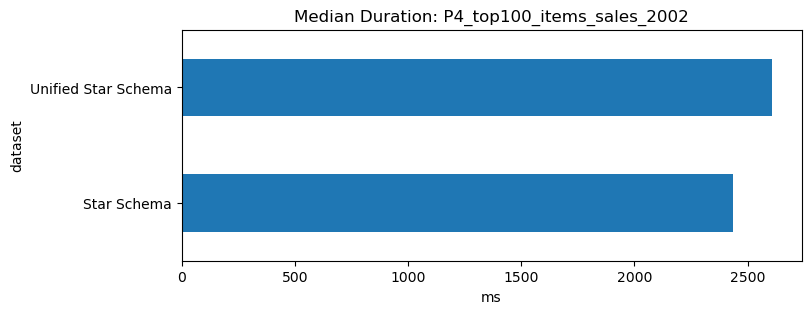

In [24]:
run_and_plot("Single Fact", "P4_top100_items_sales_2002", """
EVALUATE
TOPN(
    100,
    SUMMARIZECOLUMNS(
        'dim__item'[_key__dim__item],
        'dim__item'[category],
        TREATAS( {{ 2002 }}, 'dim__date'[year] ),
        "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
    ),
    [Sales], DESC,
    'dim__item'[_key__dim__item], ASC
)
""")

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 13, Finished, Available, Finished)

--- Running P9_inventory_wh_category_year_2002 (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


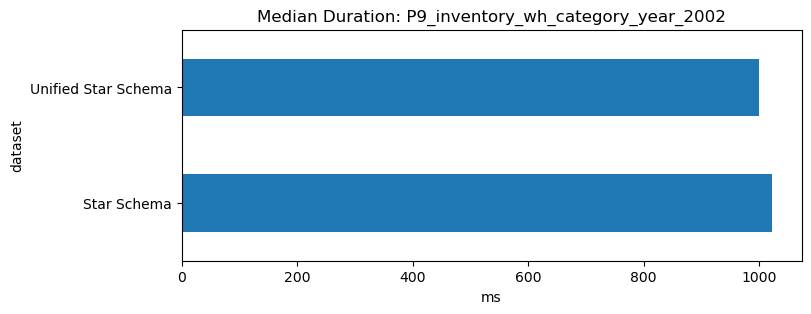

In [25]:
run_and_plot("Single Fact", "P9_inventory_wh_category_year_2002", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__warehouse'[_key__dim__warehouse],
    'dim__item'[category],
    TREATAS( {{ 2002 }}, 'dim__date'[year] ),
    "Qty On Hand", SUM('{fact_inv}'[_measure__inventory__qty_on_hand])
)
""")

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 14, Finished, Available, Finished)

--- Running P10_sales_yoy_by_year (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


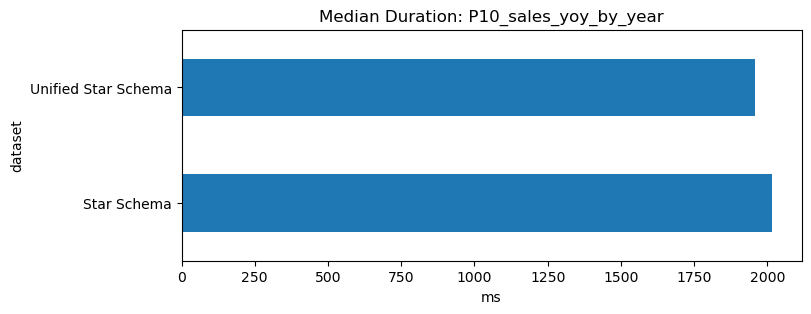

In [26]:
run_and_plot("Single Fact", "P10_sales_yoy_by_year", """
EVALUATE
ADDCOLUMNS(
    SUMMARIZECOLUMNS(
        'dim__date'[year],
        "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
    ),
    "Sales PY",
        CALCULATE(
            SUM('{fact}'[_measure__sales__ext_sales_price]),
            SAMEPERIODLASTYEAR('dim__date'[date])
        ),
    "YoY Δ",
        SUM('{fact}'[_measure__sales__ext_sales_price])
        - CALCULATE(
            SUM('{fact}'[_measure__sales__ext_sales_price]),
            SAMEPERIODLASTYEAR('dim__date'[date])
        ),
    "YoY %",
        DIVIDE(
            SUM('{fact}'[_measure__sales__ext_sales_price])
            - CALCULATE(
                SUM('{fact}'[_measure__sales__ext_sales_price]),
                SAMEPERIODLASTYEAR('dim__date'[date])
            ),
            CALCULATE(
                SUM('{fact}'[_measure__sales__ext_sales_price]),
                SAMEPERIODLASTYEAR('dim__date'[date])
            )
        )
)
ORDER BY 'dim__date'[year]
""")

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 15, Finished, Available, Finished)

--- Running P11_distinct_customers_with_orders (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


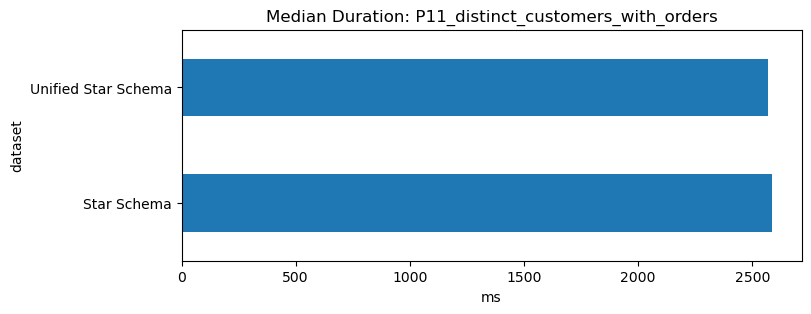

In [27]:
run_and_plot("Single Fact", "P11_distinct_customers_with_orders", """
EVALUATE
ROW(
    "Distinct Customers With Orders",
    CALCULATE(DISTINCTCOUNT('{fact}'[_key__dim__customer]), NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price]))
)
""")

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 16, Finished, Available, Finished)

--- Running P12_sales_hi_card_group (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


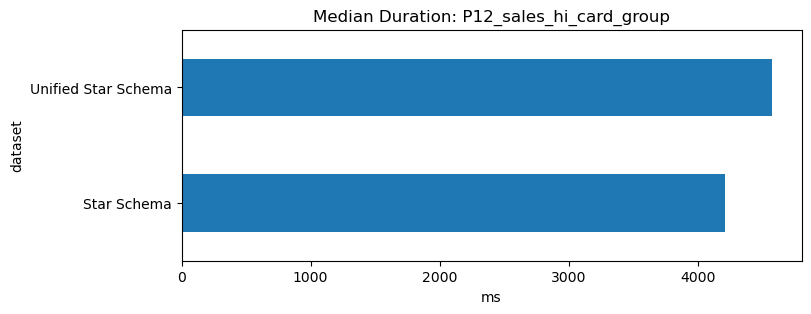

In [28]:
run_and_plot("Single Fact", "P12_sales_hi_card_group", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__date'[month_of_year],
  'dim__item'[category],
  'dim__store'[_key__dim__store],
  "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
""")

In [ ]:
run_and_plot("Single Fact", "P13_top500_items_by_year", """
EVALUATE
TOPN(
  500,
  SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__item'[_key__dim__item],
    'dim__item'[category],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
  ),
  [Sales], DESC,
  'dim__date'[year], ASC,
  'dim__item'[_key__dim__item], ASC
)
""")

StatementMeta(, 7a22d252-aaf2-4152-8c78-7be3fa5b6600, 17, Submitted, Running, Running)

--- Running P13_top500_items_by_year (Single Fact) ---
[SS] Stop reason: completed


In [ ]:
run_and_plot("Single Fact", "P15_sales_rolling_90d_by_category", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__date'[month_of_year],
  'dim__item'[category],
  "Sales 90D",
    CALCULATE(
      SUM('{fact}'[_measure__sales__ext_sales_price]),
      DATESINPERIOD('dim__date'[date], MAX('dim__date'[date]), -90, DAY)
    )
)
""")

In [ ]:
run_and_plot("Single Fact", "P18_new_customers_yoy", """
EVALUATE
VAR CustThisYear =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
VAR CustPriorYear =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    SAMEPERIODLASTYEAR('dim__date'[date]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
RETURN
ROW(
  "New Customers (YoY)",
  COUNTROWS( EXCEPT(CustThisYear, CustPriorYear) )
)
""")

In [ ]:
run_and_plot("Single Fact", "P19_distinct_customers_hi_card", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__item'[category],
  'dim__store'[_key__dim__store],
  "Distinct Customers",
    CALCULATE(
      DISTINCTCOUNT('{fact}'[_key__dim__customer]),
      NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
    )
)
""")

In [ ]:
run_and_plot("Single Fact", "P20_hi_card_30d_distinct_customers", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__item'[_key__dim__item],
  "Distinct Customers 30D",
    CALCULATE(
      DISTINCTCOUNT('{fact}'[_key__dim__customer]),
      DATESINPERIOD('dim__date'[date], MAX('dim__date'[date]), -30, DAY)
    )
)
""")

In [ ]:
run_and_plot("Single Fact", "P21_massive_group_distinct_customers_day_item_store", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__date'[month_of_year],
  'dim__item'[_key__dim__item],
  'dim__store'[_key__dim__store],
  "Distinct Customers",
    DISTINCTCOUNT('{fact}'[_key__dim__customer])
)
""")

### Multi Fact

In [ ]:
run_and_plot("Multi Fact", "P5_net_sales_by_month", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__date'[month_of_year],
    "Sales",   SUM('{fact}'[_measure__sales__ext_sales_price]),
    "Returns", SUM('{fact_ret}'[_measure__returns__return_amt]),
    "Net",
        SUM('{fact}'[_measure__sales__ext_sales_price])
        - SUM('{fact_ret}'[_measure__returns__return_amt])
)
ORDER BY 'dim__date'[year], 'dim__date'[month_of_year]
""")

In [ ]:
run_and_plot("Multi Fact", "P14_return_rate_by_year_category", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__item'[category],
  "Sales",   SUM('{fact}'[_measure__sales__ext_sales_price]),
  "Returns", SUM('{fact_ret}'[_measure__returns__return_amt]),
  "Return Rate",
    DIVIDE(
      SUM('{fact_ret}'[_measure__returns__return_amt]),
      SUM('{fact}'[_measure__sales__ext_sales_price])
    )
)
ORDER BY 'dim__date'[year], 'dim__item'[category]
""")

In [ ]:
run_and_plot("Multi Fact", "P16_distinct_customers_sales_or_returns", """
EVALUATE
VAR CustSales =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
VAR CustReturns =
  CALCULATETABLE(
    VALUES('{fact_ret}'[_key__dim__customer]),
    NOT ISBLANK('{fact_ret}'[_measure__returns__return_amt])
  )
RETURN
ROW(
  "Distinct Customers (Sales OR Returns)",
  COUNTROWS( DISTINCT( UNION(CustSales, CustReturns) ) )
)
""")

In [ ]:
run_and_plot("Multi Fact", "P17_customers_sales_and_returns", """
EVALUATE
VAR CustSales =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
VAR CustReturns =
  CALCULATETABLE(
    VALUES('{fact_ret}'[_key__dim__customer]),
    NOT ISBLANK('{fact_ret}'[_measure__returns__return_amt])
  )
RETURN
ROW(
  "Customers (Sales AND Returns)",
  COUNTROWS( INTERSECT(CustSales, CustReturns) )
)
""")

In [ ]:
run_and_plot("Multi Fact", "P22_cross_fact_union_distinct_customers_heavy_grouping", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__item'[category],
  'dim__store'[_key__dim__store],
  "Distinct Customers (Sales OR Returns)",
  VAR CustSales =
    CALCULATETABLE(
      SELECTCOLUMNS(
        VALUES('{fact}'[_key__dim__customer]),
        "CustomerKey", '{fact}'[_key__dim__customer]
      ),
      NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
    )
  VAR CustReturns =
    CALCULATETABLE(
      SELECTCOLUMNS(
        VALUES('{fact_ret}'[_key__dim__customer]),
        "CustomerKey", '{fact_ret}'[_key__dim__customer]
      ),
      NOT ISBLANK('{fact_ret}'[_measure__returns__return_amt])
    )
  RETURN
    COUNTROWS( DISTINCT( UNION(CustSales, CustReturns) ) )
)
""")

In [ ]:
run_and_plot("Multi Fact", "P23_two_fact_separate_aggregates_not_union_friendly", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__store'[_key__dim__store],
  "Sales (all items)",
    CALCULATE(
      SUM('{fact}'[_measure__sales__ext_sales_price]),
      REMOVEFILTERS('dim__item')
    ),
  "Returns (all reasons)",
    CALCULATE(
      SUM('{fact_ret}'[_measure__returns__return_amt]),
      REMOVEFILTERS('dim__reason')
    ),
  "Return Rate",
    DIVIDE(
      CALCULATE(
        SUM('{fact_ret}'[_measure__returns__return_amt]),
        REMOVEFILTERS('dim__reason')
      ),
      CALCULATE(
        SUM('{fact}'[_measure__sales__ext_sales_price]),
        REMOVEFILTERS('dim__item')
      )
    )
)
""")

## Summarize

StatementMeta(, 35356e45-f61f-4e43-b61f-b0d0db6fafa2, 24, Finished, Available, Finished)

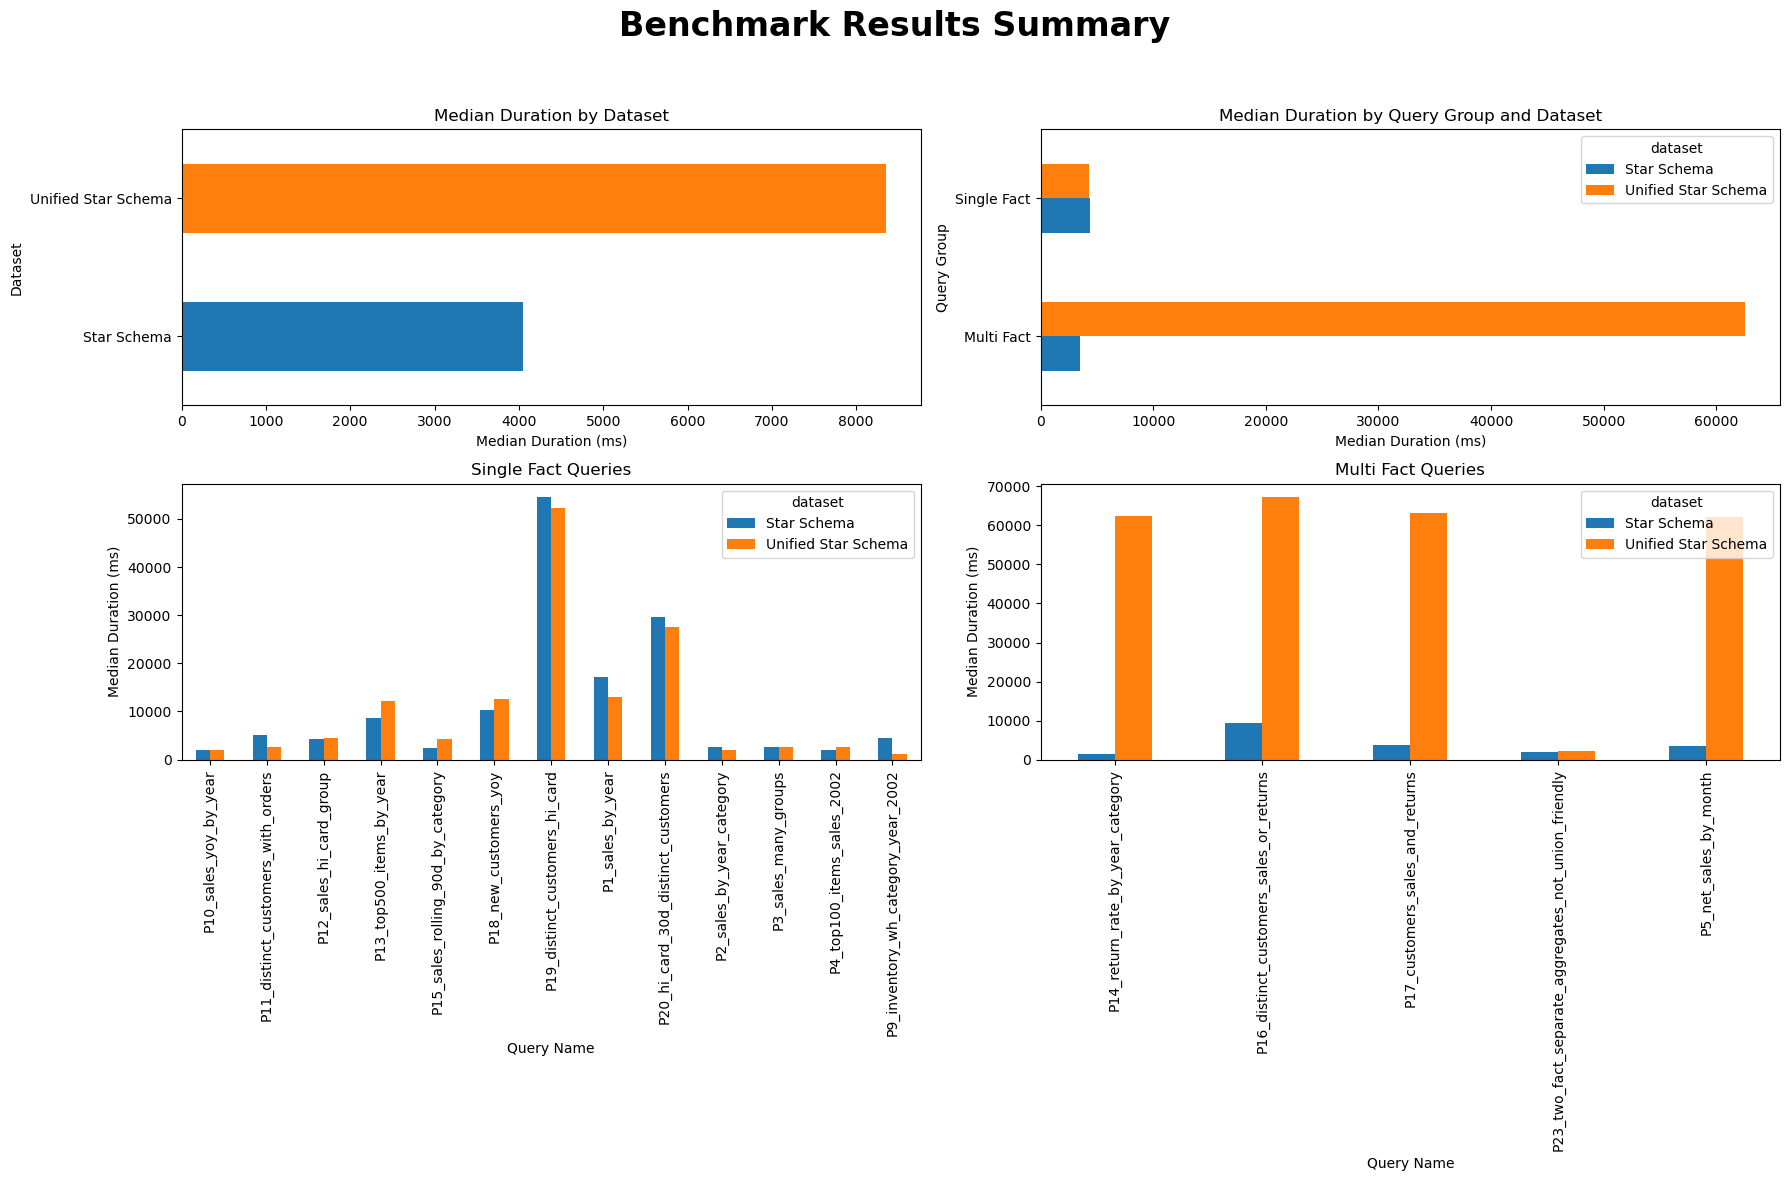

In [ ]:
# Prepare data
filtered_df = pd.DataFrame(GLOBAL_RUNS).query("phase == 'measured' and error.isna()")
dataset_df = filtered_df.groupby("dataset")["duration_ms"].median()
group_df = filtered_df.groupby(["query_group", "dataset"])["duration_ms"].median().unstack()

# Split detailed views by query group
single_fact_df = filtered_df.query("query_group == 'Single Fact'").groupby(["query_name", "dataset"])["duration_ms"].median().unstack()
multi_fact_df = filtered_df.query("query_group == 'Multi Fact'").groupby(["query_name", "dataset"])["duration_ms"].median().unstack()

# Create figure with 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Add Main Title
fig.suptitle("Benchmark Results Summary", fontsize=24, fontweight='bold')

# Top Left: Total by Dataset
dataset_df.plot.barh(
    ax=axes[0, 0],
    rot=0,
    color=[f"C{i}" for i in range(len(dataset_df))],
    title="Median Duration by Dataset"
)
axes[0, 0].set_xlabel("Median Duration (ms)")
axes[0, 0].set_ylabel("Dataset")

# Top Right: Total by Group
group_df.plot.barh(
    ax=axes[0, 1],
    rot=0,
    title="Median Duration by Query Group and Dataset"
)
axes[0, 1].set_xlabel("Median Duration (ms)")
axes[0, 1].set_ylabel("Query Group")

# Bottom Left: Single Fact Queries
if not single_fact_df.empty:
    single_fact_df.plot.bar(
        ax=axes[1, 0],
        rot=90,
        title="Single Fact Queries"
    )
    axes[1, 0].set_ylabel("Median Duration (ms)")
    axes[1, 0].set_xlabel("Query Name")

# Bottom Right: Multi Fact Queries
if not multi_fact_df.empty:
    multi_fact_df.plot.bar(
        ax=axes[1, 1],
        rot=90,
        title="Multi Fact Queries"
    )
    axes[1, 1].set_ylabel("Median Duration (ms)")
    axes[1, 1].set_xlabel("Query Name")

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()